In [26]:
import sys
import time
import copy
import math
import random
import collections

import numpy as np

from types import SimpleNamespace as SN
from typing import List, Union, Any, Set, Dict, Sequence


# agents: -1. box: -2. goal: -3. cliff: -4. Others: -5
OBS_AGENT = -1
OBS_BOX = -2
OBS_GOAL = -3
OBS_CLIFF = -4
OBS_GRID = -5

AGENT_0 = 'A'
BOX = 'B'
GOAL = 'G'
DANGER = 'x'
GRID = '_'
DEFAULT_DANGER_REGION = collections.OrderedDict({
    'A': [(2, 3), (5, 3)],
    'B': [(0, 6), (3, 6)],
    'C': [(0, 9), (2, 9)],
    'D': [(4, 9), (5, 9)],
    'E': [(2, 12), (5, 12)],
})

GOAL_POSITION = np.array([4, 13])
AGENTS_POSIITON = np.array([[5, 0]])
BOX_POSITION = np.array([4, 1])

class CliffBoxPushingBase:
    """
    Cliff Box Pushing
    """
    # all possible actions
    ACTION_NO_OP = 0  # always not available
    ACTION_UP = 1
    ACTION_DOWN = 2
    ACTION_LEFT = 3
    ACTION_RIGHT = 4
    ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
    FORCES = {
        ACTION_UP:    np.array([-1, 0]),
        ACTION_DOWN:  np.array([1,  0]),
        ACTION_LEFT:  np.array([0, -1]),
        ACTION_RIGHT: np.array([0,  1]),
    }
    def __init__(self,
                 seed=None,
                 map_name='cliffboxpushing_v0',
                 steps=100,
                 n_agents=1,
                 world_width=14,
                 world_height=6,
                 reward_offcliff=-1000,
                 obs_size=3,
                 reward_goal=0,
                 reward_agent_box_distance=True,  # enable reward for agent and box distance. DO NOT set False, else it will be very hard
                 reward_box_goal_distance=True,  # enable reward for box and goal distance. DO NOT set False, else it will be very hard
                 danger_region=DEFAULT_DANGER_REGION,
                 state_last_action=True):
        """
        Agent has an obervation of 3x3.
             _______________________________________________________
         ___|_0_|_1_|_2_|_3_|_4_|_5_|_6_|_7_|_8_|_9_|_10|_11|_12|_13|
        |_0_|___|___|___|___|___|___|_x_|___|___|_x_|___|___|___|___|
        |_1_|___|___|___|___|___|___|_x_|___|___|_x_|___|___|___|___|
        |_2_|___|___|___|_x_|___|___|_x_|___|___|_x_|___|___|_x_|___|
        |_3_|___|___|___|_x_|___|___|_x_|___|___|___|___|___|_x_|___|
        |_4_|___|_B_|___|_x_|___|___|___|___|___|_x_|___|___|_x_|_G_|
        |_5_|_A_|___|___|_x_|___|___|___|___|___|_x_|___|___|_x_|___|
        """
        self.world_width = world_width
        self.world_height = world_height
        self.reward_offcliff = reward_offcliff
        self.danger_region = SN(**danger_region)
        self.obs_size = obs_size

        self.episode_limit = steps
        self.box_attached = False
        self.reward_agent_box_distance = reward_agent_box_distance
        self.reward_box_goal_distance = reward_box_goal_distance
        self.reward_goal = reward_goal

        self.start = BOX_POSITION
        self.goal = np.array([GOAL_POSITION[0], GOAL_POSITION[1]])

        self.world = np.chararray((world_height, world_width))
        self.world[:] = GRID
        for _, region in DEFAULT_DANGER_REGION.items():
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            self.world[A[0]:B[0]+1, A[1]] = DANGER

        self.n_agents = n_agents
        self._seed = seed
        self._agent_ids = list(range(self.n_agents))
        self.curr_t = 0
        self.agent_curr_positions = copy.deepcopy(AGENTS_POSIITON)
        self.agent_pre_positions = copy.deepcopy(AGENTS_POSIITON)
        self.box_curr_position = copy.deepcopy(BOX_POSITION)
        self.box_pre_position = copy.deepcopy(BOX_POSITION)
        agent_0 = self.agent_curr_positions[0]
        
        self.world[agent_0[0], agent_0[1]] = AGENT_0
        self.world[BOX_POSITION[0], BOX_POSITION[1]] = BOX
        self.world[GOAL_POSITION[0], GOAL_POSITION[1]] = GOAL

        # states and observations
        self._state, self._obs = None, None
        self._available_actions = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]
        self._init_obs_states()

        self.episode_actions = []

    def _init_obs_states(self):
        self._init_states()
        self._init_obs()

    def _init_states(self):
        # states
        self._state = np.zeros((self.world_height, self.world_width)) + OBS_GRID
        agent_0 = self.agent_curr_positions[0]
        pos = self.box_curr_position
        self._state[agent_0[0], agent_0[1]] = OBS_AGENT
        self._state[pos[0], pos[1]] = OBS_BOX
        self._state[self.goal[0], self.goal[1]] = OBS_AGENT

        for _, region in DEFAULT_DANGER_REGION.items():
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            self._state[A[0]:B[0]+1, A[1]] = OBS_CLIFF
        self._state = self._state.flatten().tolist()

    def _init_obs(self):
        agent_0 = self.agent_curr_positions[0]
        # observation of agent 0
        obs_0 = np.zeros((self.obs_size, self.obs_size)) + OBS_GRID  # init value
        obs_0[self.obs_size//2, self.obs_size//2] = OBS_AGENT  # agent
        obs_0 = np.concatenate((obs_0.flatten(), agent_0))  # position of itself
        obs_0 = np.concatenate((obs_0, np.array([self._agent_box_distance(0)])))  # add box distance

        self._obs = obs_0

    def _update_states(self):
        self._init_states()

    def _update_agent_obs(self, agent_id):
        agent_pos = self.agent_curr_positions[agent_id]
        # observation of agent 0: basic
        obs = np.zeros((self.obs_size, self.obs_size)) + OBS_GRID  # init value
        obs[self.obs_size//2, self.obs_size//2] = OBS_AGENT  # agent

        # get box info
        if abs(agent_pos[0] - self.box_curr_position[0]) <= 1 and abs(agent_pos[1] - self.box_curr_position[1]) <= 1:
            x_diff = self.box_curr_position[0] - agent_pos[0]
            y_diff = self.box_curr_position[1] - agent_pos[1]
            obs[x_diff+1, y_diff+1] = OBS_BOX

        # get goal info
        if abs(agent_pos[0] - self.goal[0]) <= 1 and abs(agent_pos[1] - self.goal[1]) <= 1:
            x_diff = agent_pos[0] - self.goal[0]
            y_diff = agent_pos[1] - self.goal[1]
            obs[x_diff+1, y_diff+1] = OBS_GOAL

        # get cliff info. Check the position of it
        for col in [-1, 0, 1]:
            for row in [-1, 0, 1]:
                pos = [agent_pos[0] + row, agent_pos[1] + col]
                # update the obs of cliff
                for _, region in DEFAULT_DANGER_REGION.items():
                    A, B = region
                    assert A[1] == B[1], "A[1] != B[1]"
                    if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                        obs[row+1, col+1] = OBS_CLIFF

        obs = np.concatenate((obs.flatten(), agent_pos))  # position of itself
        obs = np.concatenate((obs, np.array([self._agent_box_distance(0)])))  # add box distance
        return obs

    def _update_obs(self):
        """
        Init basic data. And put other agent, box, cliff and even goal into the observation
        """
        obs_0 = self._update_agent_obs(0)
        self._obs = [obs_0]

    def _agent_box_distance(self, agent_id):
        return np.sum(np.abs(self.agent_curr_positions[agent_id] - self.box_curr_position))

    def reset(self):
        self.world = np.chararray((self.world_height, self.world_width))
        self.world[:] = GRID
        for _, region in DEFAULT_DANGER_REGION.items():
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            self.world[A[0]:B[0]+1, A[1]] = DANGER

        self.curr_t = 0
        self.agent_curr_positions = copy.deepcopy(AGENTS_POSIITON)
        self.agent_pre_positions = copy.deepcopy(AGENTS_POSIITON)
        self.box_curr_position = copy.deepcopy(self.start)
        self.box_pre_position = copy.deepcopy(self.start)
        agent_0 = self.agent_curr_positions[0]
        self.world[agent_0[0], agent_0[1]] = AGENT_0
        self.world[BOX_POSITION[0], BOX_POSITION[1]] = BOX
        self.world[GOAL_POSITION[0], GOAL_POSITION[1]] = GOAL
        self.box_attached = False

        # states and observations
        self._available_actions = [1, 1, 1, 1]
        self._init_obs_states()
        self.episode_actions = []

    def step(self, actions):
        """ 
        Returns reward, terminated, info
        """
        info = {}

        int_actions = [int(a) for a in actions]

        self.episode_actions.append(int_actions)

        self.check_box_attached()
        # Phase 1. Change the state
        # 1. is both the agent attached to the box?
        if self.box_attached:
            agent_0_force = self.FORCES[int_actions[0]]
            # check if the force is on the box
            if self.can_move_box(agent_forces=agent_0_force):
                # get the joint force
                joint_force = np.clip(agent_0_force, a_min=-1, a_max=1)
                # the box can be moved
                # check out of boundary
                box_position = self.box_curr_position + joint_force
                box_position, box_stuck = \
                    self._check_pos_boundary(pos=box_position, box_hard_boundary=True)

                self.box_curr_position = box_position
                self.update_agent_pos(agent_id=0, force=self.FORCES[int_actions[0]])
            # else move the agent
            else:
                # check agent 0, 1
                self.update_agent_pos(agent_id=0, force=self.FORCES[int_actions[0]])
                # the box is not attached to the agents now
                # check self.box_attached
                self.check_box_attached()
        # 2. else the box cannot move
        else:
            # check agent 0, 1
            self.update_agent_pos(agent_id=0, force=self.FORCES[int_actions[0]])
            # check self.box_attached
            self.check_box_attached()

        # Phase 2. calculate the rewards
        reward, terminated = self.calculate_rewards()

        # Phase 3. Update the world
        self.update_world()

        # Phase 4. Update the observations and states
        self._update_states()
        self._update_obs()
        self.curr_t += 1
        return reward, terminated, info

    def update_world(self):
        agent_0 = self.agent_curr_positions[0]
        box_pos = self.box_curr_position

        # if position changed
        if not all(self.agent_pre_positions[0] == self.agent_curr_positions[0]):
            pos = self.agent_pre_positions[0]
            if (pos[0] != self.goal[0]) or (pos[1] != self.goal[1]):
                self.world[pos[0], pos[1]] = GRID

        if not all(self.box_pre_position == self.box_curr_position):
            pos = self.box_pre_position
            if self.world[pos[0], pos[1]].decode('UTF-8') not in {AGENT_0}:
                self.world[pos[0], pos[1]] = GRID

        if (agent_0[0] != self.goal[0]) or (agent_0[1] != self.goal[1]):
            self.world[agent_0[0], agent_0[1]] = AGENT_0
        self.world[box_pos[0], box_pos[1]] = BOX

        self.box_pre_position = copy.deepcopy(self.box_curr_position)
        self.agent_pre_positions = copy.deepcopy(self.agent_curr_positions)

    def print_world(self):
        if len(self.episode_actions) > 0:
            print(f'Action: {self.episode_actions[-1]}')
        print(self.world)

    def _check_pos_boundary(self, pos, box_hard_boundary=False):
        stuck = [False, False]
        
        if pos[0] < 0:
            pos[0] = 0
            stuck[0] = True
        if pos[0] > self.world_height-1:
            pos[0] = self.world_height-1
            stuck[0] = True
        
        if pos[1] < 0:
            pos[1] = 0
            stuck[1] = True
        if pos[1] > self.world_width-1:
            pos[1] = self.world_width-1
            stuck[1] = True
        
        if box_hard_boundary:
            if pos[0] == 0:
                pos[0] += 1
                stuck[0] = True
            elif pos[0] == self.world_height-1:
                pos[0] = self.world_height-2
                stuck[0] = True

            if pos[1] == 0:
                pos[1] += 1
                stuck[1] = True
                    
        return pos, stuck

    def calculate_rewards(self):
        terminated = self.curr_t == self.episode_limit - 1
        # the distance between agents and box
        dist_0 = np.sum(np.abs(self.agent_curr_positions[0] - self.box_curr_position))
        reward = -1  # -1 for each step
        if self.reward_agent_box_distance:
            if dist_0 == 1:
                reward += -dist_0
            else:
                reward += -dist_0
        # if agents or box is off the cliff
        if self.check_agent_off_cliff(agent_id=0) or \
                self.check_box_off_cliff():
            reward += self.reward_offcliff
            terminated = True
        
        if all(self.box_curr_position == self.goal):
            if not self.reward_agent_box_distance and not self.reward_box_goal_distance:
                reward += self.reward_goal
            terminated = True
        
        if self.reward_box_goal_distance:
            reward += -np.sum(np.abs(self.box_curr_position - self.goal))

        return reward, terminated

    def check_agent_off_cliff(self, agent_id):
        pos = self.agent_curr_positions[agent_id]
        return self._check_off_cliff(pos)

    def check_box_off_cliff(self):
        pos = self.box_curr_position
        return self._check_off_cliff(pos)

    def _check_off_cliff(self, pos):
        for _, region in DEFAULT_DANGER_REGION.items():
            A, B = region
            assert A[1] == B[1], "A[1] != B[1]"
            if A[0] <= pos[0] <= B[0] and pos[1] == A[1]:
                return True
        return False

    def check_box_attached(self):
        dist_0 = np.sum(np.abs(self.agent_curr_positions[0] - self.box_curr_position))
        if dist_0 == 1:
            self.box_attached = True

    def can_move_box(self, agent_forces):
        agent_0_force = agent_forces
        if all(self.agent_curr_positions[0] + agent_0_force == self.box_curr_position):
               return True
        return False

    def update_agent_pos(self, agent_id: int, force: List[int]) -> None:
        """ Update agent's position """
        agent_position = self.agent_curr_positions[agent_id] + force
        agent_position, _ = self._check_pos_boundary(agent_position)
        if all(agent_position == self.box_curr_position):
            agent_position = self.agent_curr_positions[agent_id]
        self.agent_curr_positions[agent_id] = agent_position

    def get_obs(self):
        """ Returns all agent observations in a list """
        return self._obs

    def get_obs_agent(self, agent_id=0):
        """ Returns observation for agent_id """
        return self._obs[agent_id]

    def get_obs_size(self):
        """ Returns the shape of the observation """
        return len(self._obs[0])

    def get_state(self):
        """ Get current state: current position of both the box and agent """
        return (tuple(self.agent_curr_positions[0].tolist()), tuple(self.box_curr_position.tolist()))

    def get_state_size(self):
        """ Returns the shape of the state"""
        return 4

    def get_avail_actions(self):
        _available_actions = [1, 1, 1, 1]
        return _available_actions

    def get_avail_agent_actions(self, agent_id):
        """ Returns the available actions for agent_id """
        return self._available_actions

    def get_total_actions(self):
        """ Returns the total number of actions an agent could ever take """
        # TODO maybe there is a problem
        return len(self._available_actions)

    def render(self):
        self.print_world()

    def close(self):
        pass

    def seed(self):
        """Returns the random seed used by the environment."""
        return self._seed

    def save_replay(self):
        raise NotImplementedError

    def get_env_info(self):
        env_info = {"state_shape": self.get_state_size(),
                    "obs_shape": self.get_obs_size(),
                    "n_actions": self.get_total_actions(),
                    "n_agents": self.n_agents,
                    "episode_limit": self.episode_limit}
        return env_info

In [2]:
import sys
import time
import traceback

# from environment import CliffBoxPushingBase


if __name__ == '__main__':
    env = CliffBoxPushingBase()
    env.reset()
    terminated = False
    time_step = 0
    env.print_world()

    rewards = []
    try:
        while not terminated:
            action = [int(v) for v in \
                input("Please input the actions (up: 1, down: 2, left: 3, right: 4): ").split()]
            
            reward, terminated, _ = env.step(action)
            rewards.append(reward)
            print(f'step: {time_step}, actions: {action}, reward: {reward}')
            env.print_world()
            
            time.sleep(0.5)
            time_step += 1

        print(f'rewards: {sum(rewards)}')
        print(f'print the historical actions: {env.episode_actions}')
    except:
        print('Something wrong happened..... print the historical actions')
        print(env.episode_actions)
        ex_type, ex_value, ex_traceback = sys.exc_info()

        # Extract unformatter stack traces as tuples
        trace_back = traceback.extract_tb(ex_traceback)

        # Format stacktrace
        stack_trace = list()

        for trace in trace_back:
            stack_trace.append("File : %s , Line : %d, Func.Name : %s, Message : %s" % (trace[0], trace[1], trace[2], trace[3]))

        print("Exception type : %s " % ex_type.__name__)
        print("Exception message : %s" %ex_value)
        print("Stack trace : %s" %'\n'.join(stack_trace))

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_']]
Please input the actions (up: 1, down: 2, left: 3, right: 4): m
Something wrong happened..... print the historical actions
[]
Exception type : ValueError 
Exception message : invalid literal for int() with base 10: 'm'
Stack trace : File : /var/folders/3l/hk29ld_90zqg6tqtpjmgnv7m0000gn/T/ipykernel_57955/282790603.py , Line : 18, Func.Name : <cell line: 8>, Message : action = [int(v) for v in \
File : /var/folders/3l/hk29ld_90zqg6tqtpjmgnv7m0000gn/T/ipykernel_57955/282790603.py , Line : 18, Func.Name : <listcomp>, Message : action = [int(v) for v in \


No. of Iterations:  1723
Optimal accumulated reward:  -388


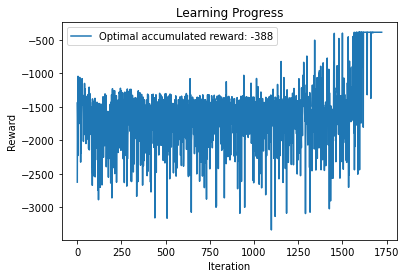

In [6]:
# from environment import CliffBoxPushingBase
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt 
import random


class QAgent(object):
    def __init__(self):
        self.action_space = [1,2,3,4]
        # create a Q-table dictionary where keys are states, values are Q-values of 4 actions, filled with zeros first
        self.Q = defaultdict(lambda: np.zeros(len(self.action_space)))
        # discount factor
        self.discount_factor=0.99
        # learning rate
        self.alpha=0.99
        # greedness, smaller means more likely to take best action
        self.epsilon=0.001

    def take_action(self, state):
        if random.random() < self.epsilon:
            action = random.choice(self.action_space)
        else:
            action = self.action_space[np.argmax(self.Q[state])]
        return action

    def train(self, state, action, next_state, reward):
        
        old_Q_value = self.Q[state][action-1]
        new_Q_value = old_Q_value + self.alpha*(reward + (self.discount_factor*np.max(self.Q[next_state])) - old_Q_value)
        self.Q[state][action-1] = new_Q_value
        pass

    
if __name__ == '__main__':
    env = CliffBoxPushingBase()
    agent = QAgent()
    terminated = False
    # Create list of rewards of each action taken in each iteration
    rewards = []
    # Assume convergence occurs when sum(rewards) for each of the latest (convergence) iterations is the same
    convergence = 50
    # Create a list of sum(rewards)
    Rewards_list = []
    time_step = 0
    # Maximum no. of iterations
    num_iterations = 3000
    for i in range(num_iterations):
        env.reset()
        while not terminated:
            # Get current state
            state = env.get_state()
            # Get action to do
            action = agent.take_action(state)
            # Perform action
            reward, terminated, _ = env.step([action])
            # Get state after action
            next_state = env.get_state()
            # Add reward value of action to rewards
            rewards.append(reward)
            time_step += 1
            # Update Q table
            agent.train(state, action, next_state, reward)
        # Change terminated back to False after exiting while loop 
        terminated = False
        # Add sum(rewards) of iteration i into Rewards_list
        Rewards_list.append(sum(rewards))
        # Reset rewards to blank for next iteration
        rewards = []
        # Exits for loop if convergence is observed
        if len(Rewards_list)>convergence and max(abs(np.diff(Rewards_list[-convergence:])))==0:
            break
#         print('Iteration: ', i, '\t Reward: ', sum(rewards))
    
    # Get converged reward value
    optimal_reward = Rewards_list[-1]
    print('No. of Iterations: ', len(Rewards_list))
    print('Optimal accumulated reward: ', optimal_reward)
    plt.plot(Rewards_list)
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.title('Learning Progress')
    plt.legend(['Optimal accumulated reward: ' + str(optimal_reward)])
    

In [16]:
import numpy as np
a = np.array([[0.511474,    0.488526],
            [0.468783,    0.531217],
            [0.35111,     0.64889],
            [0.594834,    0.405166]])
# axis=1 to find max from each row
x = np.amax(a, axis=1)
print(x)

[0.594834 0.64889 ]


In [ ]:
## Obtain V_Table and Direction_Table
## CAN IGNORE, SEE EMAIL TITLED: AI6101 Assignment for First Half Enquiries

import pandas as pd
states_list = np.asarray(list(agent.Q.keys()))
reward_list = np.asarray(list(agent.Q.values()))
agent_states_list = states_list[:,0]
box_states_list = states_list[:,1]

# print('Row idx: ', np.where(agent_status_list[:,0]==5))
# print('Column idx: ', np.where(agent_status_list[:,1]==0))

V_Table = np.zeros((env.world_height, env.world_width))
Direction_Table = np.zeros((env.world_height, env.world_width))

curr_agent_state = AGENTS_POSIITON[0]
curr_box_state = BOX_POSITION
new_agent_state = np.zeros(2)
new_box_state = np.zeros(2)

# Fill in V_Table and Direction_Table with best rewards
for row_idx in range(len(V_Table)):
    for column_idx in range(len(V_Table[0])):
        
        # list of indices where agent is at [row_idx,column_idx], but box may be anywhere else
        common_agent_idx = np.intersect1d(np.where(agent_states_list[:,0]==row_idx),np.where(agent_states_list[:,1]==column_idx))
        
        # get minimum agent-to-box-distance from the list of indices
        agent_box_dist = np.zeros(len(common_agent_idx))
        for i in range(len(common_agent_idx)):
            agent_box_dist[i] = math.sqrt((agent_states_list[common_agent_idx[i],0]-box_states_list[common_agent_idx[i],0])**2 + (agent_status_list[common_agent_idx[i],1]-box_status_list[common_agent_idx[i],1])**2)
            
            # if box is off the cliff
            if agent_box_dist[i]==1 and env._check_off_cliff(box_states_list[common_agent_idx[i]]):
                reward_list[common_agent_idx[i]] = env.reward_offcliff*np.asarray([1,1,1,1])
        
        # Accumulate rewards only when box is within a neighbouring grid
        reward_temp = []
        for i in common_agent_idx[np.argwhere(agent_box_dist<1.5)]:
            reward_temp.append(reward_list[i])
        
        # If box is not within a neighbouring grid, take rewards from nearest box
        if reward_temp ==[]:
            reward_temp = reward_list[common_agent_idx[np.argmin(agent_box_dist)]]

        # update V_Table with max reward of actions
        V_Table[row_idx,column_idx] = np.amax(reward_temp) #####
        
        # update Direction_Table with action of max reward
        Direction_Table[row_idx,column_idx] = (np.argmax(reward_temp)%4) + 1

# Replace cliff zones of V_Table grid with -1000 reward
for _, region in DEFAULT_DANGER_REGION.items():
    A, B = region
    for i in range(A[0],B[0]+1):
            V_Table[i,A[1]] = env.reward_offcliff

# Replace Agent state of V_Table depending on Box State and Action
curr_agent_state = AGENTS_POSIITON[0]
curr_box_state = BOX_POSITION
new_agent_state = np.zeros((2), dtype=int)
new_box_state = np.zeros((2), dtype=int)

print('Agent State: \t Box State: \t Action: ')
while any(new_box_state != GOAL_POSITION):
    current_agent_idx = np.intersect1d(np.where(agent_states_list[:,0]==curr_agent_state[0]),np.where(agent_states_list[:,1]==curr_agent_state[1]))
    current_box_idx = np.intersect1d(np.where(box_states_list[:,0]==curr_box_state[0]),np.where(box_states_list[:,1]==curr_box_state[1]))
    real_current_state_idx = np.intersect1d(current_agent_idx, current_box_idx)
    action = np.argmax(reward_list[real_current_state_idx])+1
    
    V_Table[curr_agent_state[0],curr_agent_state[1]] = np.amax(reward_list[real_current_state_idx])
    Direction_Table[curr_agent_state[0],curr_agent_state[1]] = action
    
    print(agent_states_list[real_current_state_idx], '\t', box_states_list[real_current_state_idx],'\t',  action)

    
    action = np.argmax(reward_list[real_current_state_idx])+1
    new_agent_state[0] = env.FORCES[action][0] + curr_agent_state[0]
    new_agent_state[1] = env.FORCES[action][1] + curr_agent_state[1]
    if all(new_agent_state == curr_box_state):
        new_box_state = [env.FORCES[action][0] + curr_box_state[0], env.FORCES[action][1] + curr_box_state[1]]
    else:
        new_box_state = curr_box_state
    curr_agent_state = new_agent_state
    curr_box_state = new_box_state


            
pd.DataFrame(V_Table)

In [ ]:
## Check box_state & corresponding rewards based on agent_state
## For V_Table
common_agent_idx = np.intersect1d(np.where(agent_status_list[:,0]==4),np.where(agent_status_list[:,1]==2))
agent_box_dist = np.zeros(len(common_agent_idx))
for i in range(len(common_agent_idx)):
    agent_box_dist[i] = math.sqrt((agent_status_list[common_agent_idx[i],0]-box_status_list[common_agent_idx[i],0])**2 + (agent_status_list[common_agent_idx[i],1]-box_status_list[common_agent_idx[i],1])**2)
#     print(agent_box_dist[i])
    print(box_status_list[common_agent_idx[i]], agent_box_dist[i], reward_list[common_agent_idx[i]])
print(np.argwhere(agent_box_dist<1.5))
# print(np.amax(reward_list[np.argwhere(agent_box_dist<1.5)]))
reward_temp = []
for i in common_agent_idx[np.argwhere(agent_box_dist<1.5)]:
    reward_temp.append(reward_list[i])
print(max(np.asarray(reward_temp).flatten()))






In [20]:
import pandas as pd
states_list = np.asarray(list(agent.Q.keys()))
reward_list = np.asarray(list(agent.Q.values()))
agent_states_list = states_list[:,0]
box_states_list = states_list[:,1]

## Path Travelled by Agent & Box
curr_agent_state = AGENTS_POSIITON[0]
curr_box_state = BOX_POSITION
new_agent_state = np.zeros((2), dtype=int)
new_box_state = np.zeros((2), dtype=int)
print('Agent State: \t Box State: \t Action: ')

while any(new_box_state != GOAL_POSITION):
    current_agent_idx = np.intersect1d(np.where(agent_states_list[:,0]==curr_agent_state[0]),np.where(agent_states_list[:,1]==curr_agent_state[1]))
    current_box_idx = np.intersect1d(np.where(box_states_list[:,0]==curr_box_state[0]),np.where(box_states_list[:,1]==curr_box_state[1]))
    real_current_state_idx = np.intersect1d(current_agent_idx, current_box_idx)
    action = np.argmax(reward_list[real_current_state_idx])+1
    
    print(agent_states_list[real_current_state_idx], '\t', box_states_list[real_current_state_idx],'\t',  action)
    new_agent_state[0] = env.FORCES[action][0] + curr_agent_state[0]
    new_agent_state[1] = env.FORCES[action][1] + curr_agent_state[1]
    if all(new_agent_state == curr_box_state):
        new_box_state = [env.FORCES[action][0] + curr_box_state[0], env.FORCES[action][1] + curr_box_state[1]]
    else:
        new_box_state = curr_box_state
    curr_agent_state = new_agent_state
    curr_box_state = new_box_state


Agent State: 	 Box State: 	 Action: 
[[5 0]] 	 [[ 4 13]] 	 1


In [24]:
# Get Q_Table
import pandas as pd
states_list = np.asarray(list(agent.Q.keys()))
agent_states_list = states_list[:,0]
box_states_list = states_list[:,1]
reward_list = np.asarray(list(agent.Q.values()))
Action_list = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Policy = []
print(len(reward_list))
print('Agent State: \t Box State: \t Action Rewards \t Policy')
np.set_printoptions(precision=8)

arr = [[0 for i in range(4)] for j in range(len(agent_states_list))]
for i in range(len(states_list)):
    if env._check_off_cliff(agent_states_list[i]) or env._check_off_cliff(box_states_list[i]):
        reward_list[i] = env.reward_offcliff*np.asarray([1,1,1,1])
    Policy.append(Action_list[np.argmax(reward_list[i])])
    arr[i][0] = agent_states_list[i]
    arr[i][1] = box_states_list[i]
    arr[i][2] = reward_list[i]
    arr[i][3] = Policy[i]
    print(agent_states_list[i], box_states_list[i], reward_list[i], Policy[i])
# pd.DataFrame(arr).to_csv("Q_Table.csv")

3
Agent State: 	 Box State: 	 Action Rewards 	 Policy
[5 0] [ 4 13] [-14.   -14.85 -14.85 -14.  ] UP
[4 0] [ 4 13] [0. 0. 0. 0.] UP
[5 1] [ 4 13] [0. 0. 0. 0.] UP


No. of Iterations:  1662
Optimal accumulated reward:  -388
Optimum Path Travelled by Agent & Box: 
Agent State: 	 Box State: 	 Action: 
[[5 0]] 	 [[4 1]] 	 RIGHT
[[5 1]] 	 [[4 1]] 	 UP
[[4 1]] 	 [[3 1]] 	 UP
[[3 1]] 	 [[2 1]] 	 UP
[[2 1]] 	 [[1 1]] 	 LEFT
[[2 0]] 	 [[1 1]] 	 UP
[[1 0]] 	 [[1 1]] 	 RIGHT
[[1 1]] 	 [[1 2]] 	 RIGHT
[[1 2]] 	 [[1 3]] 	 RIGHT
[[1 3]] 	 [[1 4]] 	 RIGHT
[[1 4]] 	 [[1 5]] 	 UP
[[0 4]] 	 [[1 5]] 	 RIGHT
[[0 5]] 	 [[1 5]] 	 DOWN
[[1 5]] 	 [[2 5]] 	 DOWN
[[2 5]] 	 [[3 5]] 	 DOWN
[[3 5]] 	 [[4 5]] 	 LEFT
[[3 4]] 	 [[4 5]] 	 DOWN
[[4 4]] 	 [[4 5]] 	 RIGHT
[[4 5]] 	 [[4 6]] 	 RIGHT
[[4 6]] 	 [[4 7]] 	 RIGHT
[[4 7]] 	 [[4 8]] 	 DOWN
[[5 7]] 	 [[4 8]] 	 RIGHT
[[5 8]] 	 [[4 8]] 	 UP
[[4 8]] 	 [[3 8]] 	 LEFT
[[4 7]] 	 [[3 8]] 	 UP
[[3 7]] 	 [[3 8]] 	 RIGHT
[[3 8]] 	 [[3 9]] 	 RIGHT
[[3 9]] 	 [[ 3 10]] 	 RIGHT
[[ 3 10]] 	 [[ 3 11]] 	 DOWN
[[ 4 10]] 	 [[ 3 11]] 	 RIGHT
[[ 4 11]] 	 [[ 3 11]] 	 UP
[[ 3 11]] 	 [[ 2 11]] 	 UP
[[ 2 11]] 	 [[ 1 11]] 	 LEFT
[[ 2 10]] 	 [[ 1 11]]

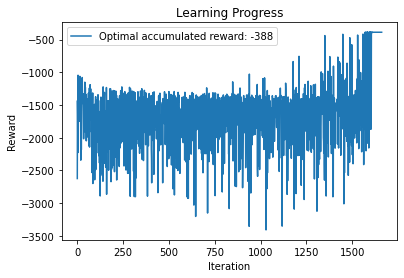

In [27]:
# from environment import CliffBoxPushingBase
from collections import defaultdict
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import random

class QAgent(object):
    def __init__(self):
        self.action_space = [1,2,3,4]
        # create a Q-table dictionary where keys are states, values are Q-values of 4 actions, filled with zeros first
        self.Q = defaultdict(lambda: np.zeros(len(self.action_space)))
        # discount factor
        self.discount_factor=0.99
        # learning rate
        self.alpha=0.99
        # greediness, smaller means more likely to take best action
        self.epsilon=0.001

    def take_action(self, state):
        if random.random() < self.epsilon:
            action = random.choice(self.action_space)
        else:
            action = self.action_space[np.argmax(self.Q[state])]
        return action

    def train(self, state, action, next_state, reward):
        
        old_Q_value = self.Q[state][action-1]
        new_Q_value = old_Q_value + self.alpha*(reward + (self.discount_factor*np.max(self.Q[next_state])) - old_Q_value)
        self.Q[state][action-1] = new_Q_value
        pass

    
if __name__ == '__main__':
    env = CliffBoxPushingBase()
    agent = QAgent()
    terminated = False
    # Create list of rewards of each action taken in each iteration
    rewards = []
    # Assume convergence occurs when sum(rewards) for each of the latest (convergence) iterations is the same
    convergence = 50
    # Create a list of sum(rewards)
    Rewards_list = []
    time_step = 0
    # Maximum no. of iterations
    num_iterations = 3000
    
    ## Training
    for i in range(num_iterations):
        env.reset()
        while not terminated:
            # Get current state
            state = env.get_state()
            # Get action to do
            action = agent.take_action(state)
            # Perform action
            reward, terminated, _ = env.step([action])
            # Get state after action
            next_state = env.get_state()
            # Add reward value of action to rewards
            rewards.append(reward)
            time_step += 1
            # Update Q table
            agent.train(state, action, next_state, reward)
        
        # Change terminated back to False after reaching terminated state 
        terminated = False
        # Add sum(rewards) of iteration i into Rewards_list
        Rewards_list.append(sum(rewards))
        # Reset rewards to blank for next iteration
        rewards = []
        # Exits for loop if convergence is observed
        if len(Rewards_list)>convergence and max(abs(np.diff(Rewards_list[-convergence:])))==0:
            break
#         print('Iteration: ', i, '\t Reward: ', sum(rewards))
    
    ## Get converged reward value and plot Learning progress
    optimal_reward = Rewards_list[-1]
    print('No. of Iterations: ', len(Rewards_list))
    print('Optimal accumulated reward: ', optimal_reward)
    plt.plot(Rewards_list)
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.title('Learning Progress')
    plt.legend(['Optimal accumulated reward: ' + str(optimal_reward)])
    
    ## Get Optimum Path Travelled by Agent & Box
    states_list = np.asarray(list(agent.Q.keys()))
    reward_list = np.asarray(list(agent.Q.values()))
    agent_states_list = states_list[:,0]
    box_states_list = states_list[:,1]

    curr_agent_state = AGENTS_POSIITON[0]
    curr_box_state = BOX_POSITION
    new_agent_state = np.zeros((2), dtype=int)
    new_box_state = np.zeros((2), dtype=int)
    Action_list = ['UP', 'DOWN', 'LEFT', 'RIGHT']
    print('Optimum Path Travelled by Agent & Box: ')
    print('Agent State: \t Box State: \t Action: ')

    while any(new_box_state != GOAL_POSITION):
        # Get best action based on current agent and box states
        current_agent_idx = np.intersect1d(np.where(agent_states_list[:,0]==curr_agent_state[0]),np.where(agent_states_list[:,1]==curr_agent_state[1]))
        current_box_idx = np.intersect1d(np.where(box_states_list[:,0]==curr_box_state[0]),np.where(box_states_list[:,1]==curr_box_state[1]))
        real_current_state_idx = np.intersect1d(current_agent_idx, current_box_idx)
        action = np.argmax(reward_list[real_current_state_idx])+1
        action_print = Action_list[action-1]
        print(agent_states_list[real_current_state_idx], '\t', box_states_list[real_current_state_idx],'\t',  action_print)
        # Update agent and box states
        new_agent_state[0] = env.FORCES[action][0] + curr_agent_state[0]
        new_agent_state[1] = env.FORCES[action][1] + curr_agent_state[1]
        if all(new_agent_state == curr_box_state):
            new_box_state = [env.FORCES[action][0] + curr_box_state[0], env.FORCES[action][1] + curr_box_state[1]]
        else:
            new_box_state = curr_box_state
        curr_agent_state = new_agent_state
        curr_box_state = new_box_state
    
    ## save Q_Table as .csv file
    states_list = np.asarray(list(agent.Q.keys()))
    agent_states_list = states_list[:,0]
    box_states_list = states_list[:,1]
    reward_list = np.asarray(list(agent.Q.values()))
    Policy = []
    print(len(reward_list))
#     print('Agent State: \t Box State: \t Action Rewards \t Policy')
    np.set_printoptions(precision=8)

    arr = [[0 for i in range(4)] for j in range(len(agent_states_list))]
    for i in range(len(states_list)):
        if env._check_off_cliff(agent_states_list[i]) or env._check_off_cliff(box_states_list[i]):
            reward_list[i] = env.reward_offcliff*np.asarray([1,1,1,1])
        Policy.append(Action_list[np.argmax(reward_list[i])])
        arr[i][0] = agent_states_list[i]
        arr[i][1] = box_states_list[i]
        arr[i][2] = reward_list[i]
        arr[i][3] = Policy[i]
#         print(agent_states_list[i], box_states_list[i], reward_list[i], Policy[i])
    pd.DataFrame(arr).to_csv("Q_Table.csv", header=None,index=None)